In [3]:
import pandas as pd
from utils.constants import Paths

In [4]:
df = pd.read_parquet(Paths.PROCESSED_DATA_PARQUET / "aggregated_pothole.parquet")

In [5]:
df = df[df["num_requests"] >= 0]

In [6]:
df["year_month"] = df["date_created"].dt.to_period("M")

In [7]:
df = df[df["population_density"] > 100]

In [8]:
from shapely.ops import unary_union
from shapely.wkt import loads

In [9]:
# use wkt load to convert the string to a shapely object
df["geometry"] = df["geometry"].apply(loads)

In [10]:
describe_columns = [
    "median_age",
    "hispanic_pct",
    "white_nh_pct",
    "black_nh_pct",
    "asian_nh_pct",
    "average_hh_size",
    "less_than_hs_pct",
    "hs_pct",
    "some_college_pct",
    "associate_degree_pct",
    "bachelors_or_higher_pct",
    "median_household_income",
]

In [11]:
grouped_df = (
    df.groupby(["borough","neighborhood","street", "year_month"])
    .agg(
        {
            "date_created": "size",
            "rating": "mean",
            "population_density": "mean",
            "street_length": "mean",
            "geometry": lambda x: unary_union(x).centroid,
            "median_age": "mean",
            "hispanic_pct": "mean",
            "white_nh_pct": "mean",
            "black_nh_pct": "mean",
            "asian_nh_pct": "mean",
            "average_hh_size": "mean",
            "less_than_hs_pct": "mean",
            "hs_pct": "mean",
            "some_college_pct": "mean",
            "associate_degree_pct": "mean",
            "bachelors_or_higher_pct": "mean",
            "median_household_income": "mean",
            }
    )
    .reset_index()
)
grouped_df.rename(columns={"date_created": "report_count"}, inplace=True)

# this formula is subject to change
# grouped_df['reporting_ratio'] = grouped_df['report_count'] / grouped_df['rating']

- Find reporting rate for entire set (baseline)
- Find reporting rate for each neighborhood
- Divide to find over/underreporting rate

- Implement street length (normalize by that too)
  - Look at similar length streets
  - If conditions are good, look at # of reports


In [12]:
grouped_df["reporting_ratio"] = grouped_df["report_count"] / (
    grouped_df["population_density"] * grouped_df["street_length"]
)

In [13]:
#get 75th percentile of reporting ratio
reporting_ratio_threshold = grouped_df["reporting_ratio"].quantile(0.80)

grouped_df = grouped_df[grouped_df["reporting_ratio"] < reporting_ratio_threshold]

<Axes: ylabel='Frequency'>

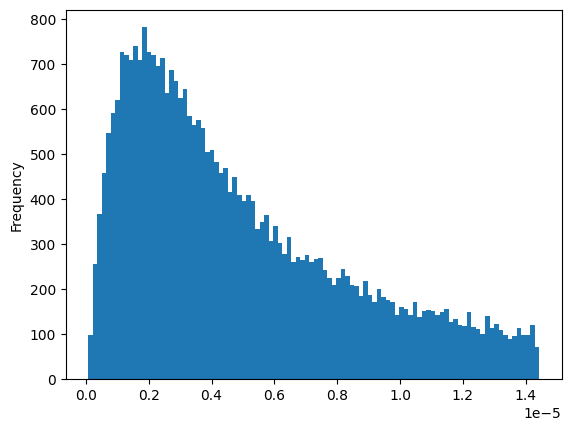

In [14]:
grouped_df['reporting_ratio'].plot.hist(bins=100)

In [15]:
import matplotlib.pyplot as plt

In [16]:
grouped_df["normalized_reporting_ratio"] = 1 + 9 * (
    (grouped_df["reporting_ratio"] - grouped_df["reporting_ratio"].min())
    / (grouped_df["reporting_ratio"].max() - grouped_df["reporting_ratio"].min())
)

In [17]:
average_reporting_ratio = grouped_df["normalized_reporting_ratio"].mean()

In [18]:
average_reporting_ratio

4.048002621936796

<Axes: ylabel='Frequency'>

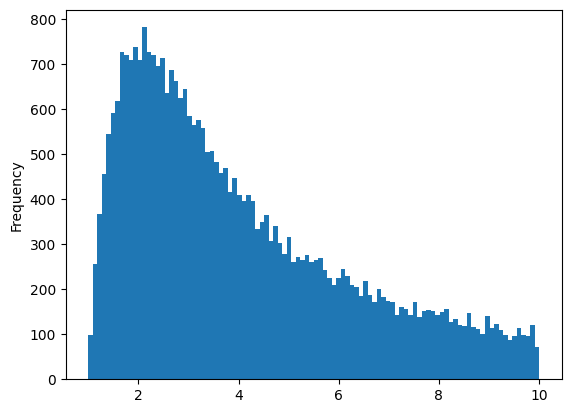

In [19]:
grouped_df['normalized_reporting_ratio'].plot.hist(bins=100)

In [20]:
import geopandas as gpd
import matplotlib.colors as colors
import numpy as np
import contextily as ctx
import matplotlib.pyplot as plt

In [21]:
grouped_gdf = gpd.GeoDataFrame(grouped_df, geometry="geometry", crs="3857")

In [22]:
grouped_gdf['reporting_difference'] = grouped_gdf['normalized_reporting_ratio'] - grouped_gdf['rating']

In [23]:
grouped_gdf['reporting_difference_v2'] = grouped_gdf['normalized_reporting_ratio'] - average_reporting_ratio

In [24]:
grouped_gdf['reporting_difference'].max(), grouped_gdf['reporting_difference'].min()

(8.95484210530893, -7.988437866978957)

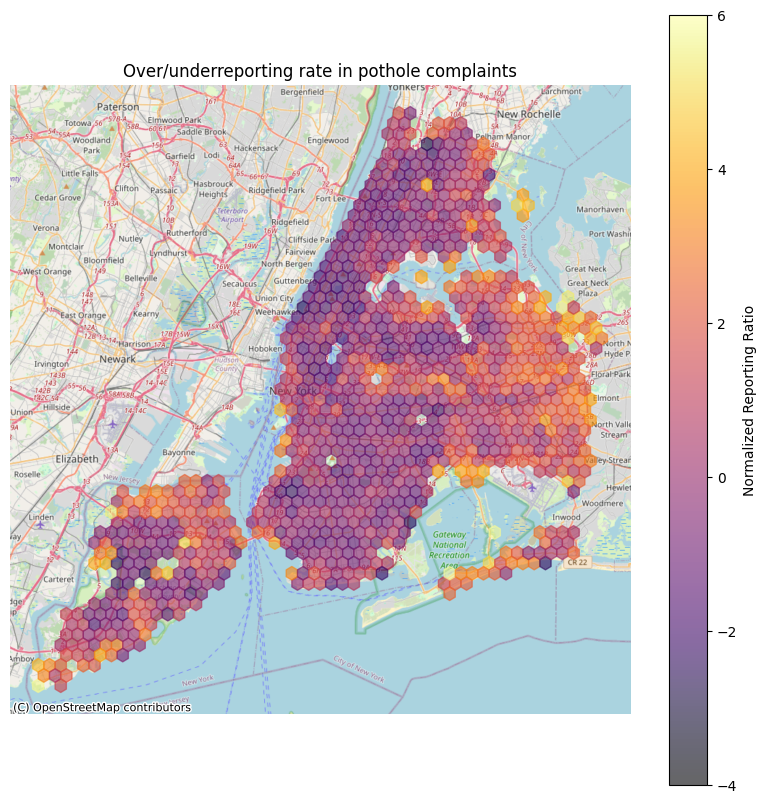

In [25]:
norm = colors.Normalize(vmin=-4, vmax=6)

tile_provider = ctx.providers.OpenStreetMap.Mapnik

fig, ax = plt.subplots(figsize=(10, 10))


x = grouped_gdf.geometry.x
y = grouped_gdf.geometry.y

hb = ax.hexbin(x, y, C=grouped_gdf['reporting_difference_v2'], gridsize=50, reduce_C_function=np.mean, cmap='inferno', alpha=0.6, norm=norm)
cb = fig.colorbar(hb, ax=ax)
cb.set_label('Normalized Reporting Ratio')

# Add the basemap
ctx.add_basemap(ax, crs=grouped_gdf.crs.to_string(), source=tile_provider)

plt.title('Over/underreporting rate in pothole complaints')
plt.axis('off')
plt.show()

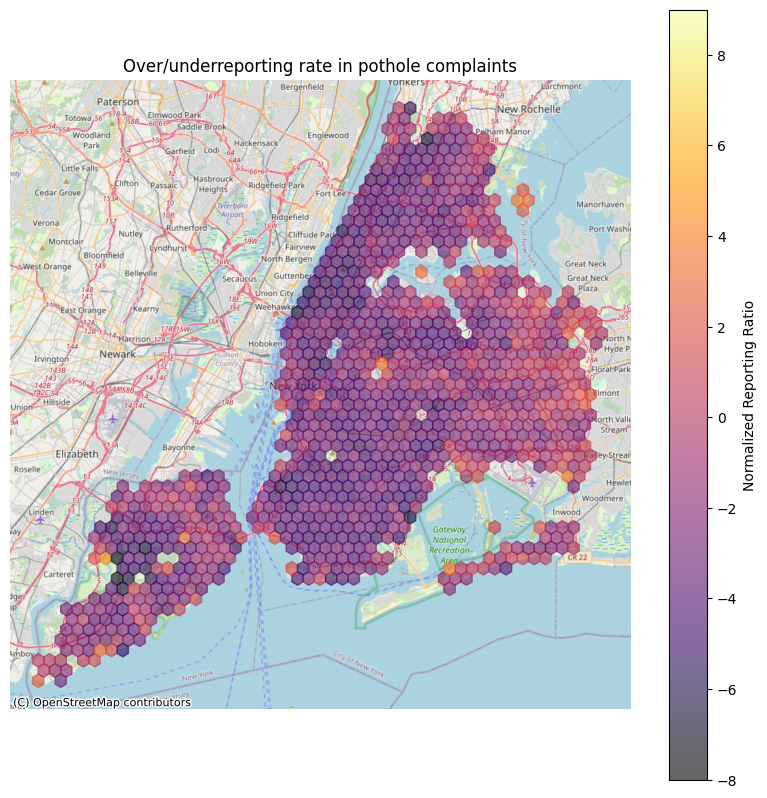

In [26]:
norm = colors.Normalize(vmin=-8, vmax=9)

tile_provider = ctx.providers.OpenStreetMap.Mapnik

fig, ax = plt.subplots(figsize=(10, 10))


x = grouped_gdf.geometry.x
y = grouped_gdf.geometry.y

hb = ax.hexbin(x, y, C=grouped_gdf['reporting_difference'], gridsize=50, reduce_C_function=np.mean, cmap='inferno', alpha=0.6, norm=norm)
cb = fig.colorbar(hb, ax=ax)
cb.set_label('Normalized Reporting Ratio')

# Add the basemap
ctx.add_basemap(ax, crs=grouped_gdf.crs.to_string(), source=tile_provider)

plt.title('Over/underreporting rate in pothole complaints')
plt.axis('off')
plt.show()

In [27]:
# remove null values in describe_columns
grouped_gdf = grouped_gdf.dropna(subset=describe_columns)

In [28]:
import seaborn as sns

<Axes: >

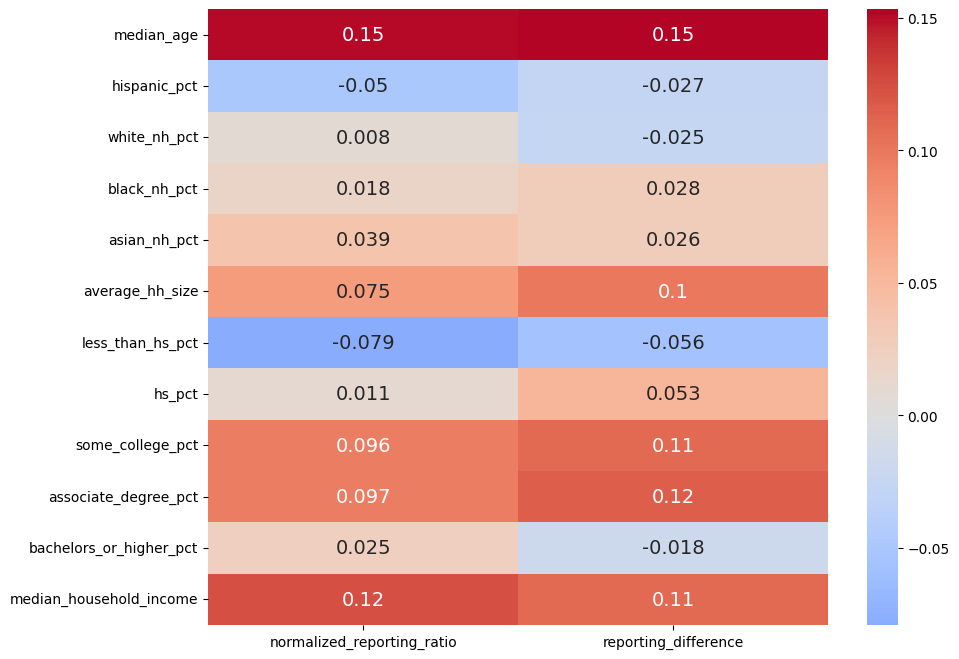

In [31]:
selected_cols = describe_columns + ['normalized_reporting_ratio','reporting_difference'] 
corr = grouped_gdf[selected_cols].corr(method='spearman') 
corr = corr.loc[['normalized_reporting_ratio','reporting_difference'],describe_columns] 
plt.figure(figsize=(10, 8)) 
sns.heatmap(corr.T, annot=True, cmap='coolwarm', center=0, annot_kws={"size": 14})

In [32]:
from tabulate import tabulate

In [38]:
copy = grouped_gdf.copy()

In [41]:
# Copy the DataFrame to avoid changing the original data
df_copy = copy.copy()

# Truncate the 'neighborhood' column
df_copy['neighborhood'] = df_copy['neighborhood'].apply(lambda x: (x[:10] + '..') if len(x) > 10 else x)

# Print the table
print(tabulate(df_copy.sort_values(by="normalized_reporting_ratio",ascending=False).head(15), headers='keys', tablefmt="psql", showindex=False))

+---------------+----------------+--------------+----------------+----------+----------------------+-----------------+-----------------------------------------------+--------------+----------------+----------------+----------------+----------------+-------------------+--------------------+----------+--------------------+------------------------+---------------------------+---------------------------+-------------------+------------------------------+------------------------+---------------------------+
| borough       | neighborhood   | year_month   |   report_count |   rating |   population_density |   street_length | geometry                                      |   median_age |   hispanic_pct |   white_nh_pct |   black_nh_pct |   asian_nh_pct |   average_hh_size |   less_than_hs_pct |   hs_pct |   some_college_pct |   associate_degree_pct |   bachelors_or_higher_pct |   median_household_income |   reporting_ratio |   normalized_reporting_ratio |   reporting_difference |   reporting_

In [42]:
print(tabulate(copy.sort_values(by="normalized_reporting_ratio",ascending=False).head(15), headers='keys', tablefmt="psql", showindex=False))

+---------------+-------------------------------------+--------------+----------------+----------+----------------------+-----------------+-----------------------------------------------+--------------+----------------+----------------+----------------+----------------+-------------------+--------------------+----------+--------------------+------------------------+---------------------------+---------------------------+-------------------+------------------------------+------------------------+---------------------------+
| borough       | neighborhood                        | year_month   |   report_count |   rating |   population_density |   street_length | geometry                                      |   median_age |   hispanic_pct |   white_nh_pct |   black_nh_pct |   asian_nh_pct |   average_hh_size |   less_than_hs_pct |   hs_pct |   some_college_pct |   associate_degree_pct |   bachelors_or_higher_pct |   median_household_income |   reporting_ratio |   normalized_reporting_rat

NameError: name 'selected_cols' is not defined

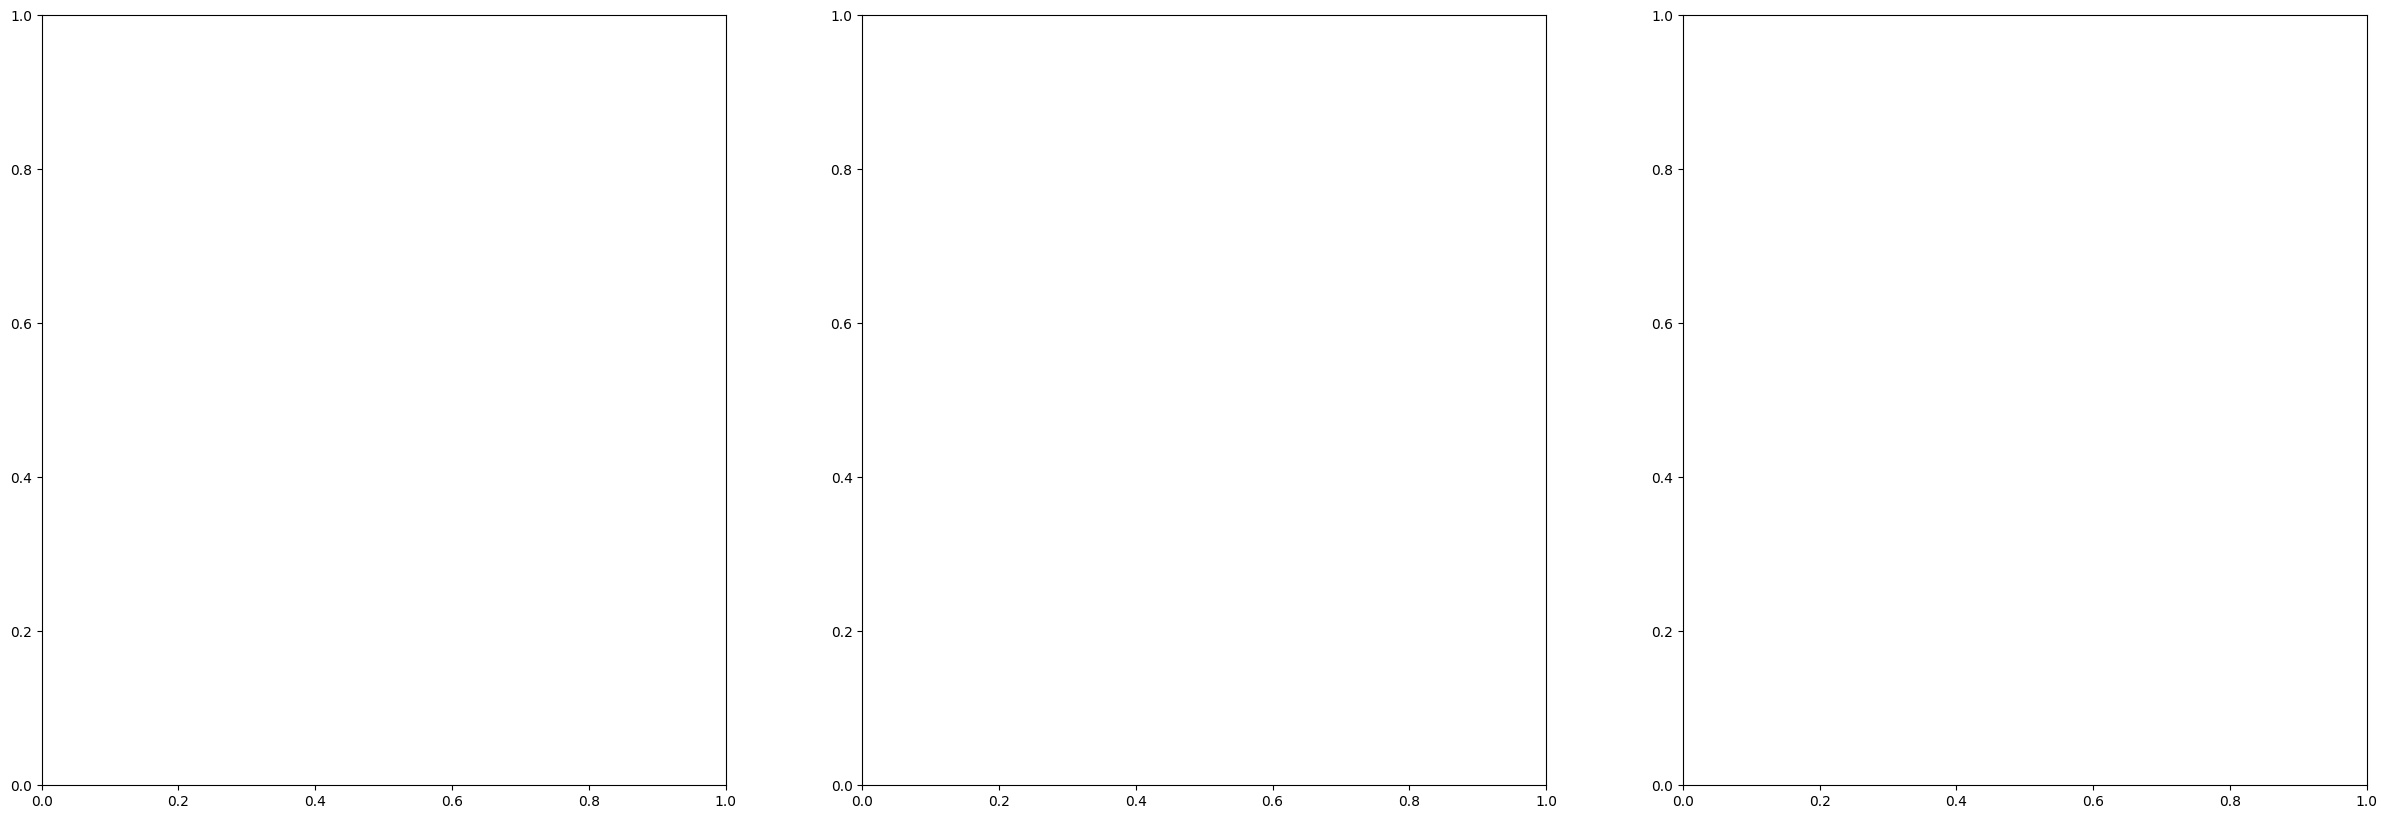

In [28]:
fig, axs = plt.subplots(ncols=3, figsize=(30, 10))

# Pearson correlation
corr_pearson = grouped_gdf[selected_cols].corr(method='pearson')
corr_pearson = corr_pearson.loc[['normalized_reporting_ratio','reporting_difference'],describe_columns]
sns.heatmap(corr_pearson.T, annot=True, cmap='coolwarm', center=0, ax=axs[0])
axs[0].set_title('Pearson')

# Kendall correlation
corr_kendall = grouped_gdf[selected_cols].corr(method='kendall')
corr_kendall = corr_kendall.loc[['normalized_reporting_ratio','reporting_difference'],describe_columns]
sns.heatmap(corr_kendall.T, annot=True, cmap='coolwarm', center=0, ax=axs[1])
axs[1].set_title('Kendall')

# Spearman correlation
corr_spearman = grouped_gdf[selected_cols].corr(method='spearman')
corr_spearman = corr_spearman.loc[['normalized_reporting_ratio','reporting_difference'],describe_columns]
sns.heatmap(corr_spearman.T, annot=True, cmap='coolwarm', center=0, ax=axs[2])
axs[2].set_title('Spearman')

plt.tight_layout()
plt.show()

In [ ]:
X = grouped_gdf[describe_columns]
y = grouped_gdf['reporting_difference']

In [ ]:
pd.set_option('display.float_format', '{:.10e}'.format)

In [ ]:
from scipy.stats import pearsonr, kendalltau, spearmanr

# Create a DataFrame to store the p-values
p_values = pd.DataFrame(index=describe_columns, 
                        columns=['Pearson', 'Kendall', 'Spearman'])

# Calculate the p-values
for column in describe_columns:
    _, p_value_pearson = pearsonr(X[column], y)
    _, p_value_kendall = kendalltau(X[column], y)
    _, p_value_spearman = spearmanr(X[column], y)

    
    p_values.loc[column, 'Pearson'] = p_value_pearson
    p_values.loc[column, 'Kendall'] = p_value_kendall
    p_values.loc[column, 'Spearman'] = p_value_spearman

# Display the p-values


In [ ]:
p_values

,Pearson,Kendall,Spearman
median_age,9.5171222906e-32,2.8800029883e-114,3.5395518573e-104
hispanic_pct,0.0000000000e+00,0.0000000000e+00,0.0000000000e+00
white_nh_pct,0.0000000000e+00,0.0000000000e+00,0.0000000000e+00
black_nh_pct,7.1464870045e-06,1.2566821811e-86,8.2796416495e-111
asian_nh_pct,8.1230210831e-27,4.5278642125e-36,1.0277284639e-52
average_hh_size,1.8767258971e-299,0.0000000000e+00,0.0000000000e+00
less_than_hs_pct,1.2823241143e-278,1.0064367568e-176,5.0600771691e-186
hs_pct,8.4882922268e-177,1.3905385106e-236,1.1291803356e-256
some_college_pct,9.9443824757e-01,6.3966560472e-13,4.5543424258e-14
associate_degree_pct,2.5174819468e-04,1.6802397690e-20,1.7419572147e-18


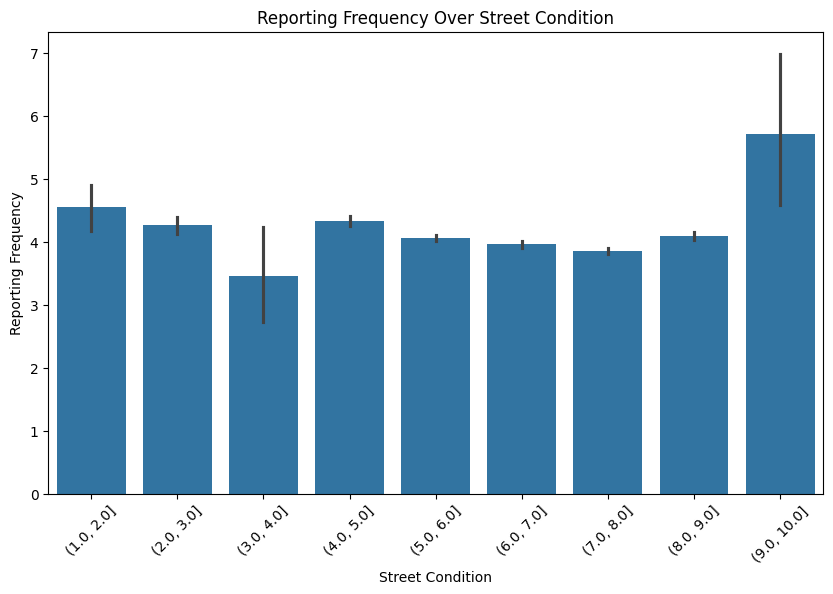

In [29]:
bins = np.linspace(grouped_gdf['rating'].min(), grouped_gdf['rating'].max(), 10)

# Create a new column for the binned street condition
grouped_gdf['binned_street_condition'] = pd.cut(grouped_gdf['rating'], bins)

# Plot the reporting frequency over the binned street condition
plt.figure(figsize=(10, 6))
sns.barplot(x='binned_street_condition', y='normalized_reporting_ratio', data=grouped_gdf)
plt.title('Reporting Frequency Over Street Condition')
plt.xlabel('Street Condition')
plt.ylabel('Reporting Frequency')
plt.xticks(rotation=45)
plt.show()

- [ ] Look at reporting frequency over street condition 
- [ ] Look at demographics of manhattan/brooklyn/queens as a whole to see correlation
- [ ] For each discrete street rating look at distribution of normalized reporting ratio of each group (demographic groups (ex: education types))

In [30]:
borough_demographics = grouped_gdf.groupby('borough').agg({
    "median_age": "mean",
    "hispanic_pct": "mean",
    "white_nh_pct": "mean",
    "black_nh_pct": "mean",
    "asian_nh_pct": "mean",
    "average_hh_size": "mean",
    "less_than_hs_pct": "mean",
    "hs_pct": "mean",
    "some_college_pct": "mean",
    "associate_degree_pct": "mean",
    "bachelors_or_higher_pct": "mean",
    "median_household_income": "mean",
})

In [31]:
pd.reset_option('display.float_format')

In [32]:
bins = np.linspace(grouped_df['normalized_reporting_ratio'].min(), grouped_df['normalized_reporting_ratio'].max(), 11)
labels = range(1, 11)

# Create a new column for the discrete rating
grouped_df['discrete_normalized_reporting_ratio'] = pd.cut(grouped_df['normalized_reporting_ratio'], bins=bins, labels=labels)

In [34]:
groups = {
    "education_columns": ["less_than_hs_pct", "hs_pct", "some_college_pct", "associate_degree_pct", "bachelors_or_higher_pct"],
    "race_columns": ["hispanic_pct", "white_nh_pct", "black_nh_pct", "asian_nh_pct"],
    "other_columns": ["median_age", "average_hh_size", "median_household_income"]
}

for group_name, columns in groups.items():
    plt.figure(figsize=(10, 6))
    for column in columns:
        mean_values = grouped_df.groupby('discrete_normalized_reporting_ratio')[column].mean()
        std_values = grouped_df.groupby('discrete_normalized_reporting_ratio')[column].std()
        plt.errorbar(mean_values.index, mean_values.values, yerr=std_values.values, marker='o', capsize=5, label=column)
    plt.title(f'Mean Values Across Discrete Street Ratings for {group_name}')
    plt.xlabel('Discrete Street Rating')
    plt.ylabel('Mean Values')
    plt.xticks(range(1, 11))
    plt.grid(True)
    plt.legend()
    plt.savefig(f'{group_name}.png')
    plt.close()

/var/folders/_f/vkg_0cs10979h47nv_958bdw0000gp/T/ipykernel_85203/1678577568.py:10: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  mean_values = grouped_df.groupby('discrete_normalized_reporting_ratio')[column].mean()
/var/folders/_f/vkg_0cs10979h47nv_958bdw0000gp/T/ipykernel_85203/1678577568.py:11: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  std_values = grouped_df.groupby('discrete_normalized_reporting_ratio')[column].std()


In [99]:
race_columns = ["hispanic_pct", "white_nh_pct", "black_nh_pct", "asian_nh_pct"]
other_columns = ["median_age", "average_hh_size", "median_household_income"]

def create_plots(columns, filename):
    fig, axs = plt.subplots(len(columns), figsize=(10, 6*len(columns)))
    for ax, column in zip(axs, columns):
        mean_values = grouped_df.groupby('discrete_normalized_reporting_ratio')[column].mean()
        std_values = grouped_df.groupby('discrete_normalized_reporting_ratio')[column].std()
        ax.errorbar(mean_values.index, mean_values.values, yerr=std_values.values, marker='o', capsize=5)
        ax.set_title(f'Mean {column} Across Discrete Normalized Reporting Ratio')
        ax.set_xlabel('Discrete Normalized Reporting Ratio')
        ax.set_ylabel(f'Mean {column}')
        ax.set_xticks(range(1, 11))
        ax.grid(True)
    plt.tight_layout()
    plt.savefig(f'{filename}_reporting_ratio.png')
    plt.close()

create_plots(race_columns, 'race_plots')
create_plots(other_columns, 'other_plots')

/var/folders/_f/vkg_0cs10979h47nv_958bdw0000gp/T/ipykernel_61326/2976329684.py:7: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  mean_values = grouped_df.groupby('discrete_normalized_reporting_ratio')[column].mean()
/var/folders/_f/vkg_0cs10979h47nv_958bdw0000gp/T/ipykernel_61326/2976329684.py:8: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  std_values = grouped_df.groupby('discrete_normalized_reporting_ratio')[column].std()


/var/folders/_f/vkg_0cs10979h47nv_958bdw0000gp/T/ipykernel_61326/3460528616.py:6: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  mean_values = grouped_df.groupby('discrete_normalized_reporting_ratio')[column].mean()
/var/folders/_f/vkg_0cs10979h47nv_958bdw0000gp/T/ipykernel_61326/3460528616.py:7: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  std_values = grouped_df.groupby('discrete_normalized_reporting_ratio')[column].std()


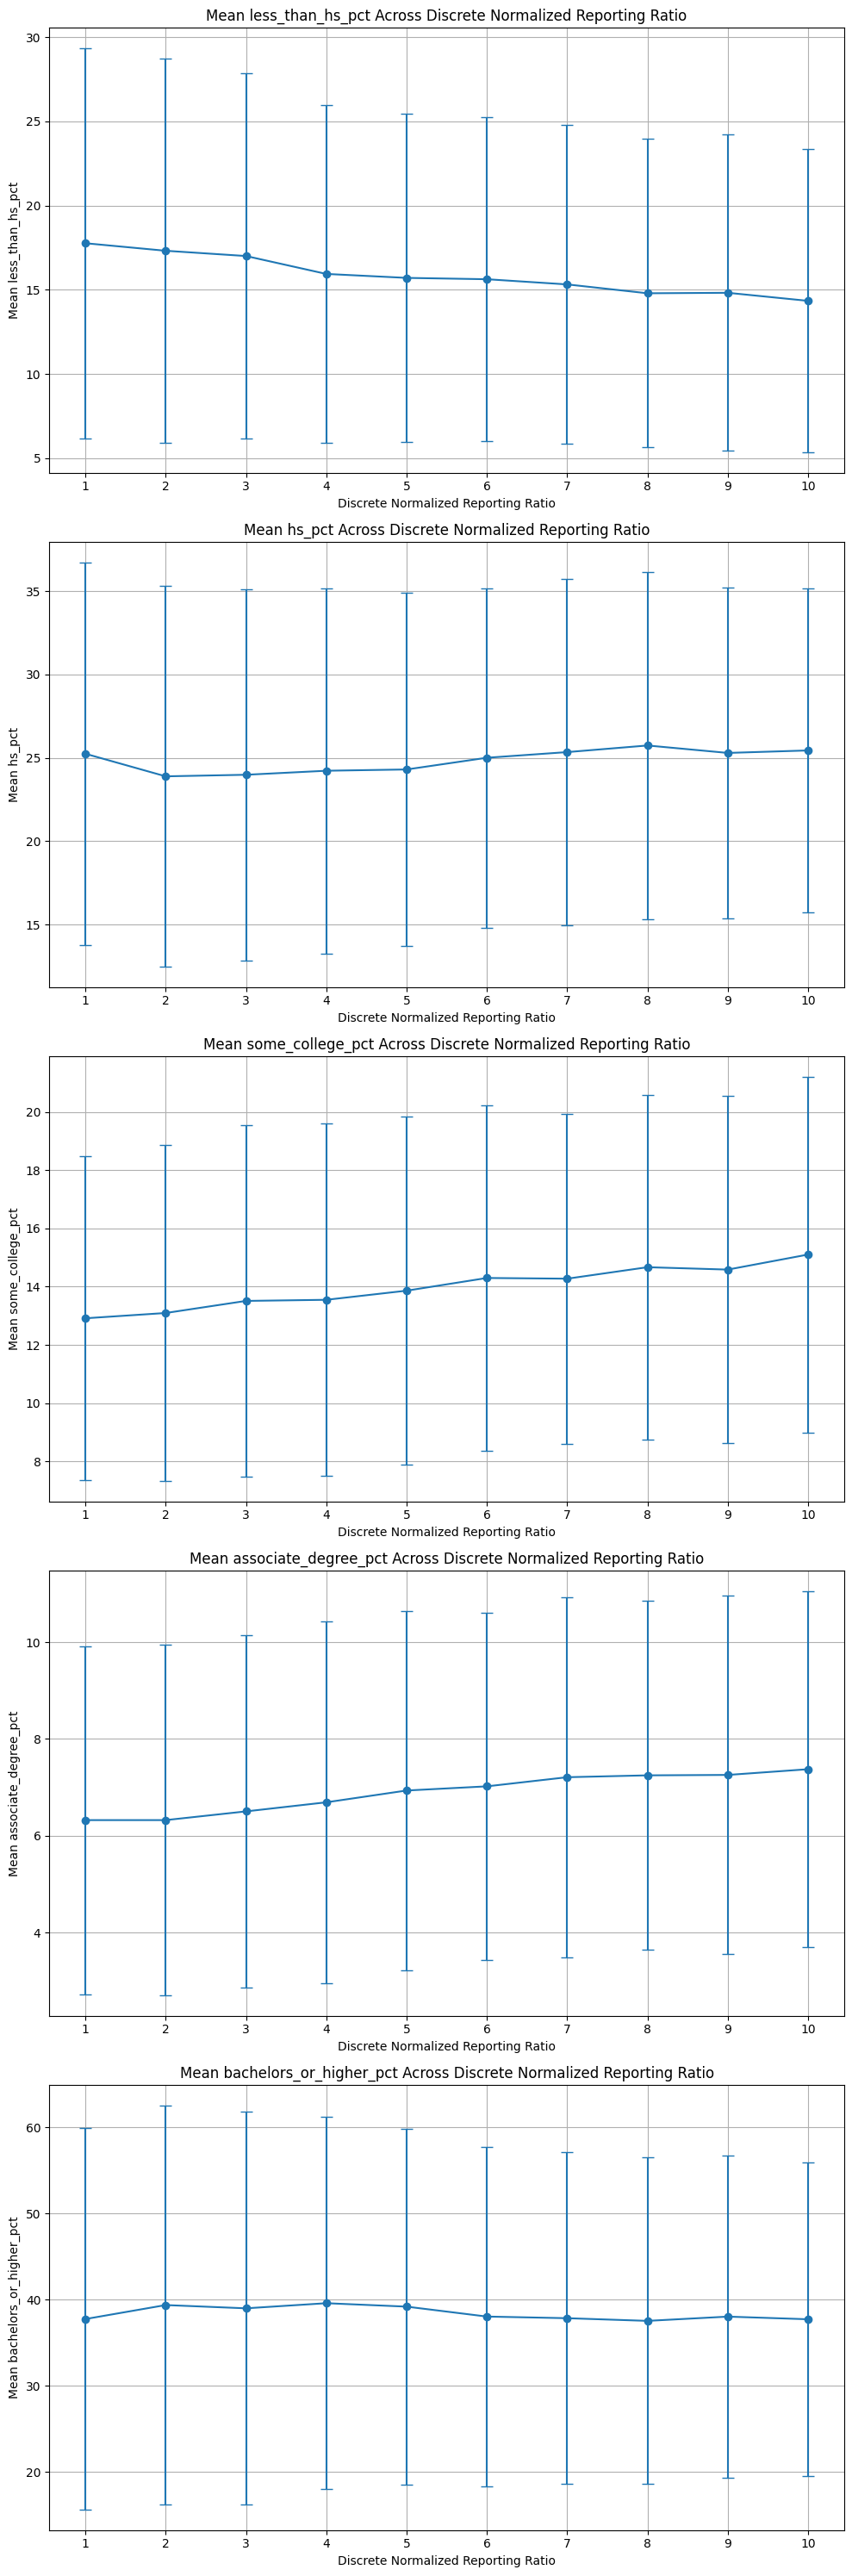

In [100]:
education_columns = ["less_than_hs_pct", "hs_pct", "some_college_pct", "associate_degree_pct", "bachelors_or_higher_pct"]

fig, axs = plt.subplots(len(education_columns), figsize=(10, 6*len(education_columns)))

for ax, column in zip(axs, education_columns):
    mean_values = grouped_df.groupby('discrete_normalized_reporting_ratio')[column].mean()
    std_values = grouped_df.groupby('discrete_normalized_reporting_ratio')[column].std()
    ax.errorbar(mean_values.index, mean_values.values, yerr=std_values.values, marker='o', capsize=5)
    ax.set_title(f'Mean {column} Across Discrete Normalized Reporting Ratio')
    ax.set_xlabel('Discrete Normalized Reporting Ratio')
    ax.set_ylabel(f'Mean {column}')
    ax.set_xticks(range(1, 11))
    ax.grid(True)

plt.tight_layout()
plt.savefig('education_plots_reporting_ratio.png')

In [ ]:
education_columns = ["less_than_hs_pct", "hs_pct", "some_college_pct", "associate_degree_pct", "bachelors_or_higher_pct"]

for column in education_columns:
    mean_values = grouped_df.groupby('discrete_rating')[column].mean()
    std_values = grouped_df.groupby('discrete_rating')[column].std()
    plt.figure(figsize=(10, 6))
    plt.errorbar(mean_values.index, mean_values.values, yerr=std_values.values, marker='o', capsize=5)
    plt.title(f'Mean {column} Across Discrete Street Ratings')
    plt.xlabel('Discrete Street Rating')
    plt.ylabel(f'Mean {column}')
    plt.xticks(range(1, 11))
    plt.grid(True)
    plt.show()

In [ ]:
education_columns = ["less_than_hs_pct", "hs_pct", "some_college_pct", "associate_degree_pct", "bachelors_or_higher_pct"]

for column in education_columns:
    mean_values = grouped_df.groupby('discrete_rating')[column].mean()
    std_values = grouped_df.groupby('discrete_rating')[column].std()
    plt.figure(figsize=(10, 6))
    plt.errorbar(mean_values.index, mean_values.values, yerr=std_values.values, marker='o', capsize=5)
    plt.title(f'Mean {column} Across Discrete Street Ratings')
    plt.xlabel('Discrete Street Rating')
    plt.ylabel(f'Mean {column}')
    plt.xticks(range(1, 11))
    plt.grid(True)
    plt.show()

In [ ]:
education_columns = ["less_than_hs_pct", "hs_pct", "some_college_pct", "associate_degree_pct", "bachelors_or_higher_pct"]

for column in education_columns:
    mean_values = grouped_df.groupby('discrete_rating')[column].mean()
    std_values = grouped_df.groupby('discrete_rating')[column].std()
    plt.figure(figsize=(10, 6))
    plt.errorbar(mean_values.index, mean_values.values, yerr=std_values.values, marker='o', capsize=5)
    plt.title(f'Mean {column} Across Discrete Street Ratings')
    plt.xlabel('Discrete Street Rating')
    plt.ylabel(f'Mean {column}')
    plt.xticks(range(1, 11))
    plt.grid(True)
    plt.show()

In [ ]:
education_columns = ["less_than_hs_pct", "hs_pct", "some_college_pct", "associate_degree_pct", "bachelors_or_higher_pct"]

for column in education_columns:
    mean_values = grouped_df.groupby('discrete_rating')[column].mean()
    std_values = grouped_df.groupby('discrete_rating')[column].std()
    plt.figure(figsize=(10, 6))
    plt.errorbar(mean_values.index, mean_values.values, yerr=std_values.values, marker='o', capsize=5)
    plt.title(f'Mean {column} Across Discrete Street Ratings')
    plt.xlabel('Discrete Street Rating')
    plt.ylabel(f'Mean {column}')
    plt.xticks(range(1, 11))
    plt.grid(True)
    plt.show()

In [ ]:
education_columns = ["less_than_hs_pct", "hs_pct", "some_college_pct", "associate_degree_pct", "bachelors_or_higher_pct"]

for column in education_columns:
    mean_values = grouped_df.groupby('discrete_rating')[column].mean()
    std_values = grouped_df.groupby('discrete_rating')[column].std()
    plt.figure(figsize=(10, 6))
    plt.errorbar(mean_values.index, mean_values.values, yerr=std_values.values, marker='o', capsize=5)
    plt.title(f'Mean {column} Across Discrete Street Ratings')
    plt.xlabel('Discrete Street Rating')
    plt.ylabel(f'Mean {column}')
    plt.xticks(range(1, 11))
    plt.grid(True)
    plt.show()

In [ ]:
education_columns = ["less_than_hs_pct", "hs_pct", "some_college_pct", "associate_degree_pct", "bachelors_or_higher_pct"]

for column in education_columns:
    mean_values = grouped_df.groupby('discrete_rating')[column].mean()
    std_values = grouped_df.groupby('discrete_rating')[column].std()
    plt.figure(figsize=(10, 6))
    plt.errorbar(mean_values.index, mean_values.values, yerr=std_values.values, marker='o', capsize=5)
    plt.title(f'Mean {column} Across Discrete Street Ratings')
    plt.xlabel('Discrete Street Rating')
    plt.ylabel(f'Mean {column}')
    plt.xticks(range(1, 11))
    plt.grid(True)
    plt.show()

In [81]:
borough_demographics

,median_age,hispanic_pct,white_nh_pct,black_nh_pct,asian_nh_pct,average_hh_size,less_than_hs_pct,hs_pct,some_college_pct,associate_degree_pct,bachelors_or_higher_pct,median_household_income
borough,,,,,,,,,,,,
Bronx,37.005324,51.230068,12.764755,27.404912,5.115891,2.714185,23.545098,27.388744,16.711823,7.987819,24.367072,57816.873667
Brooklyn,35.744040,19.597825,36.101579,26.028056,12.686342,2.735389,15.839196,24.999483,12.478759,6.177326,40.504356,86216.265001
Manhattan,37.719466,21.396178,49.738351,9.751910,14.419002,1.971520,10.008605,10.829628,8.758417,3.243503,67.161466,124793.396555
Queens,39.290229,26.762659,23.177745,16.757044,26.337227,2.912859,17.386899,26.481142,14.304009,7.607204,34.217438,87200.594236
Staten Island,41.333543,17.795949,60.045927,6.999159,12.207139,2.816516,11.334840,30.028930,15.990198,7.561402,35.073068,101573.048915


In [86]:
from sklearn.model_selection import train_test_split

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=0)

In [99]:
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LinearRegression
from sklearn import metrics

# Define independent variables (predictors) and dependent variable (response)
X = grouped_gdf[describe_columns]
y = grouped_gdf['reporting_difference']

# Split the data into training set and test set
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=0)

# Create a LinearRegression object
regressor = LinearRegression()

# Fit the model
regressor.fit(X_train, y_train)

# Make predictions
y_pred = regressor.predict(X_test)

# Print the coefficients
print('Coefficients: \n', regressor.coef_)

# Print the mean squared error
print('Mean squared error: %.2f'
    % metrics.mean_squared_error(y_test, y_pred))

# Print the coefficient of determination: 1 is perfect prediction
print('Coefficient of determination: %.2f'
    % metrics.r2_score(y_test, y_pred))

Coefficients: 
 [ 5.62225873e-02 -1.75872293e-02 -2.13582295e-02 -1.81440955e-02
 -1.34079475e-02  5.32083215e-01 -1.11165857e+00 -1.08168791e+00
 -1.05443878e+00 -1.04910829e+00 -1.09407493e+00  9.14627181e-06]
Mean squared error: 7.27
Coefficient of determination: 0.06


In [87]:
from sklearn.ensemble import RandomForestRegressor

# Create a RandomForestRegressor object
rf_regressor = RandomForestRegressor(n_estimators=100, random_state=0)

# Fit the model
rf_regressor.fit(X_train, y_train)

# Make predictions
y_pred_rf = rf_regressor.predict(X_test)

# Print the mean squared error
print('Mean squared error: %.2f'
    % metrics.mean_squared_error(y_test, y_pred_rf))

# Print the coefficient of determination: 1 is perfect prediction
print('Coefficient of determination: %.2f'
    % metrics.r2_score(y_test, y_pred_rf))

Mean squared error: 5.37
Coefficient of determination: 0.31


In [89]:
from sklearn.ensemble import GradientBoostingRegressor

# Create a GradientBoostingRegressor object
gb_regressor = GradientBoostingRegressor(n_estimators=100, random_state=0)

# Fit the model
gb_regressor.fit(X_train, y_train)

# Make predictions
y_pred_gb = gb_regressor.predict(X_test)

# Print the mean squared error
print('Mean squared error: %.2f'
    % metrics.mean_squared_error(y_test, y_pred_gb))

# Print the coefficient of determination: 1 is perfect prediction
print('Coefficient of determination: %.2f'
    % metrics.r2_score(y_test, y_pred_gb))

Mean squared error: 6.33
Coefficient of determination: 0.18


In [ ]:
census_df = pd.read_parquet(Paths.PROCESSED_DATA_PARQUET / "census_data.parquet")

: 

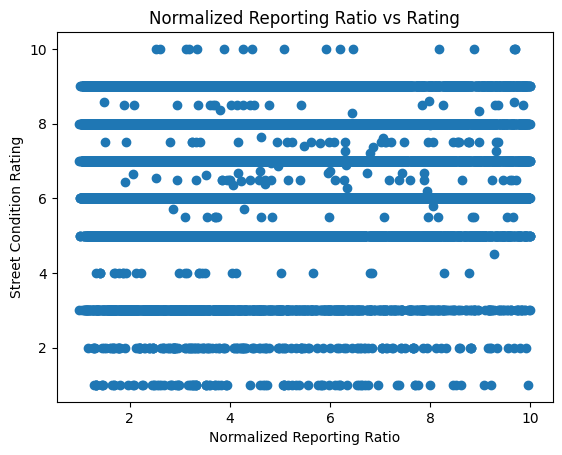

In [98]:
plt.scatter(x=grouped_gdf['normalized_reporting_ratio'], y=grouped_gdf['rating'])
plt.xlabel('Normalized Reporting Ratio')
plt.ylabel('Street Condition Rating')
plt.title('Normalized Reporting Ratio vs Rating')
plt.show()

<Axes: >

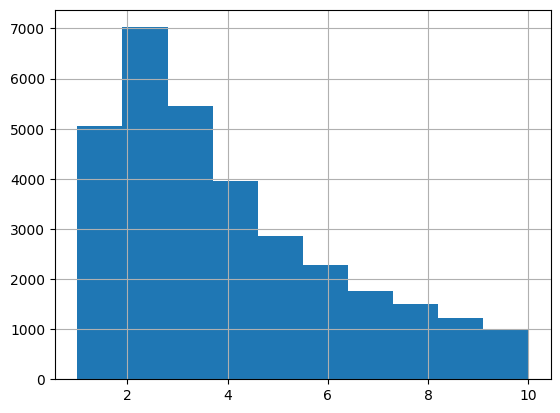

In [100]:
grouped_gdf['normalized_reporting_ratio'].hist()